# Verificador de SPAM
---
O objetivo desse projeto é desenvolver um classificador para verificar se determinada mensagem é SPAM ou não

In [1]:
!pip install nltk

In [2]:
import nltk
import pandas as pd
import seaborn as sns
import string
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Lendo o arquivo e transformando-o num DataFrame

In [3]:
messages = [line.rstrip() for line in open('SMSSpamCollection')]

In [4]:
label_list = []
text_list = []

for i in range(len(messages)):
  label_list.append(messages[i].split('\t')[0])
  text_list.append(messages[i].split('\t')[1])

df = pd.DataFrame(dict(zip(text_list, label_list)), index=['label']).T.reset_index().rename(columns={'index':'text'})

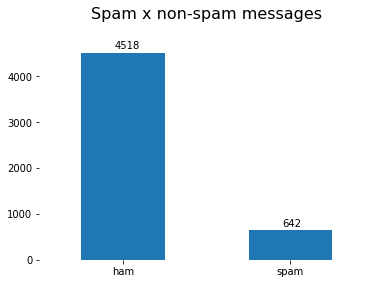

In [5]:
ax = df.label.value_counts().plot(kind='bar')
plt.box(False)
plt.title('Spam x non-spam messages\n',fontsize=16)
plt.xticks(rotation=360)
for b in ax.patches:
  plt.annotate(f"{b.get_height()}",(b.get_x()+ 0.2 , b.get_height()+80))

In [6]:
df.label.value_counts()

ham     4518
spam     642
Name: label, dtype: int64

Agora vamos criar uma coluna com o tamanho dos textos das mensagens

In [7]:
df['length'] = df['text'].apply(lambda x: len(x))

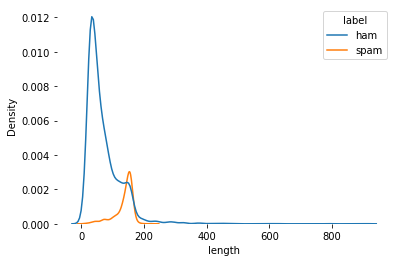

In [8]:
sns.kdeplot(x='length', hue='label', data=df)
plt.box(False)

Podemos notar uma clara diferença entre mensagens spam e não spam. Essa diferença está na concentração do tamanho das mensagens.

# Pré-processamento

Primeiro criamos a função que tira as pontuações e depois tira as stopwords

In [9]:
def pre_processing(mess):
  sem_pont = [letra for letra in mess if letra not in string.punctuation]
  texto = ''.join(sem_pont)
  sem_stop = [palavra for palavra in texto.split() if palavra.lower() not in stopwords.words('english')]
  return sem_stop

Aplicando

In [10]:
df['text_clean'] = df['text'].apply(pre_processing)

Não utilizaremos essa coluna, mas aplicaremos a função para criar nosso transformador

In [11]:
transformer = CountVectorizer(analyzer=pre_processing).fit(df['text'])

In [12]:
text3 = transformer.transform([df['text'][3]])

In [13]:
textos = transformer.transform([df['text']])

## Método TF-idf
---
A ideia do TF-idf é redimensionar a frequência das palavras pela frequência com que aparecem em todos os documentos.

In [14]:
from sklearn.feature_extraction.text import TfidfTransformer

In [15]:
transformer_tf = TfidfTransformer()
transformer_tf = transformer_tf.fit(textos)

Vamos ver um exemplo:

In [16]:
tfidf4 = transformer_tf.transform(text3)
print(tfidf4)

  (0, 9554)	0.5187068876586773
  (0, 7186)	0.43912355218815696
  (0, 6222)	0.25935344382933867
  (0, 6204)	0.25935344382933867
  (0, 5261)	0.25935344382933867
  (0, 4629)	0.25935344382933867
  (0, 4068)	0.5187068876586773


## Modelagem preditiva

**Modelo Naive Bayes**

In [17]:
from sklearn.naive_bayes import MultinomialNB
import numpy as np
from sklearn.model_selection import train_test_split

In [18]:
text_tfidf = transformer_tf.transform(textos)

Separando em treino e teste

In [19]:
txt_treino, txt_teste, label_treino, label_teste = train_test_split(df['text'], df['label'])

O scikit learn nos fornece a função Pipeline

In [20]:
from sklearn.pipeline import Pipeline

In [21]:
pipeline = Pipeline([
                    ('bow', CountVectorizer()),
                    ('tfidf', TfidfTransformer()),
                    ('classifiet', MultinomialNB())
])

In [22]:
pipeline.fit(txt_treino, label_treino)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifiet',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [23]:
pred = pipeline.predict(df['text'])

## Avaliando o modelo
---
Para avaliar nosso classificador, vamos utilizar o relatório de classificação e a matriz de confusão.

In [24]:
from sklearn.metrics import classification_report, confusion_matrix

In [25]:
print(classification_report(df['label'], pred))

              precision    recall  f1-score   support

         ham       0.96      1.00      0.98      4518
        spam       1.00      0.71      0.83       642

    accuracy                           0.96      5160
   macro avg       0.98      0.86      0.91      5160
weighted avg       0.97      0.96      0.96      5160



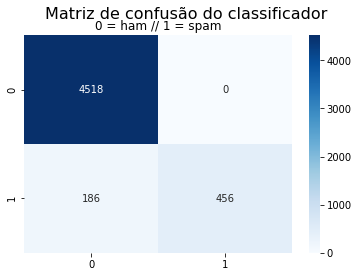

In [28]:
sns.heatmap(confusion_matrix(df['label'], pred), annot=True, cmap='Blues', fmt='g')
plt.suptitle('Matriz de confusão do classificador\n', fontsize=16)
plt.title('0 = ham // 1 = spam');

Nosso modelo demonstrou um bom desempenho, conseguimos classificar as mensagems que são e as que não são spam com uma precisão alta.